# 1. Loading libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

house-prices-advanced-regression-techniques



# 1. Getting the Data

In [2]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 2. Exploring the Data

In [4]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(df_train.shape))
print("The test data size before dropping Id feature is : {} ".format(df_test.shape))

#Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(df_train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(df_test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


In [5]:
df_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [6]:
df_train['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64


 mu = 180921.20 and sigma = 79415.29



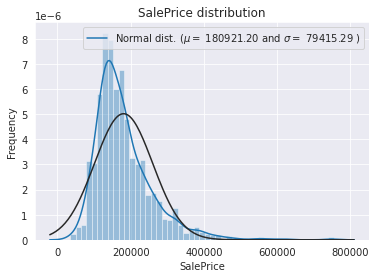

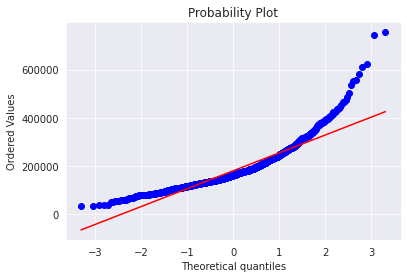

In [7]:
sns.distplot(df_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

In [8]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


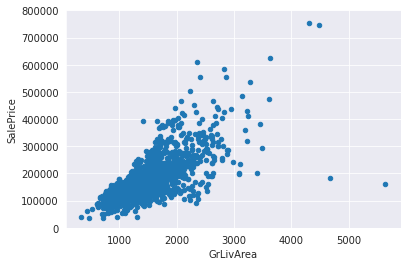

In [9]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

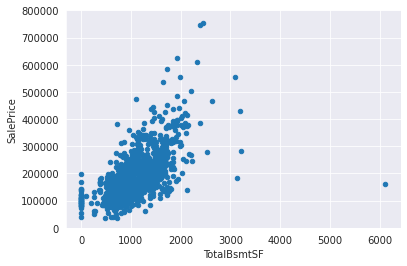

In [10]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

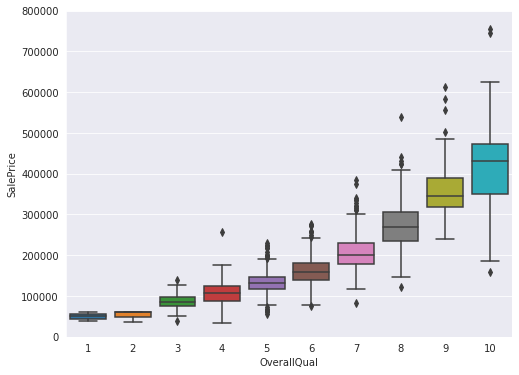

In [11]:
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

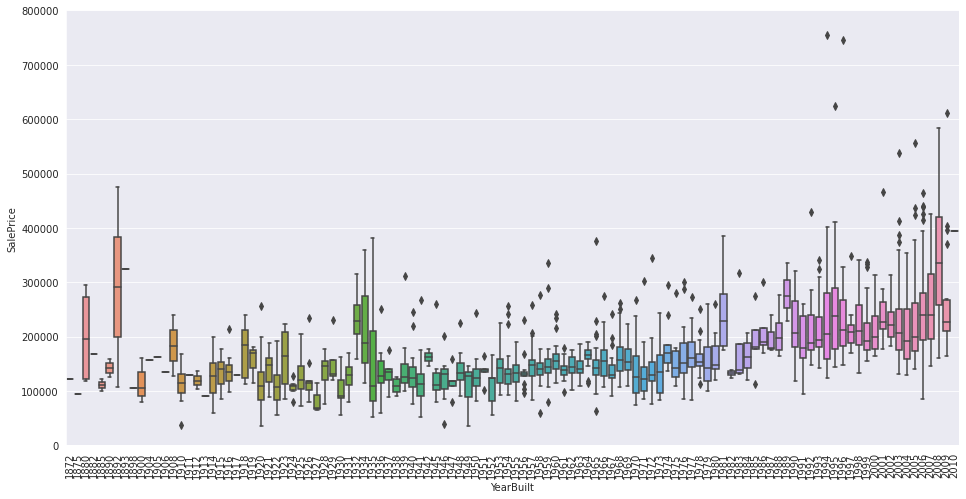

In [12]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

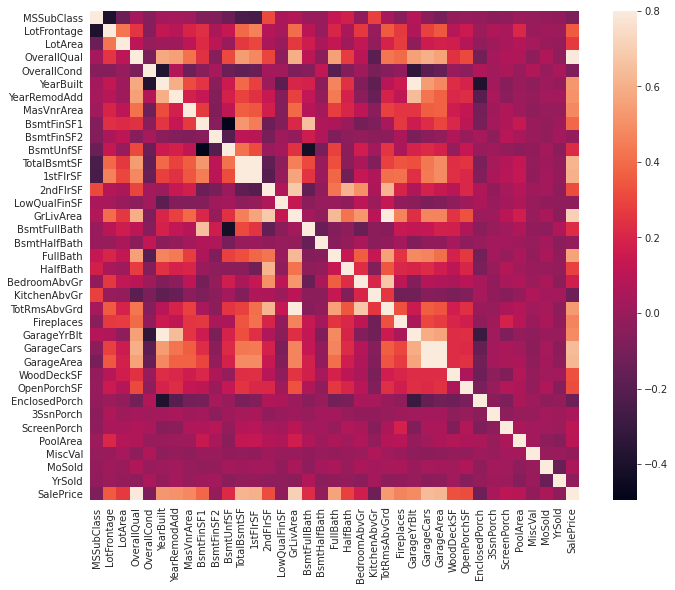

In [13]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

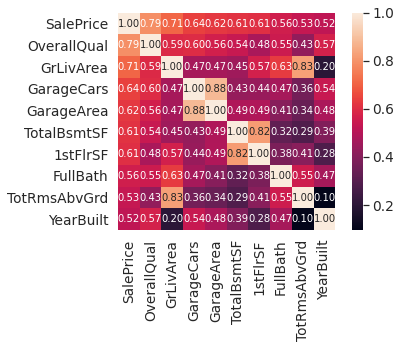

In [14]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

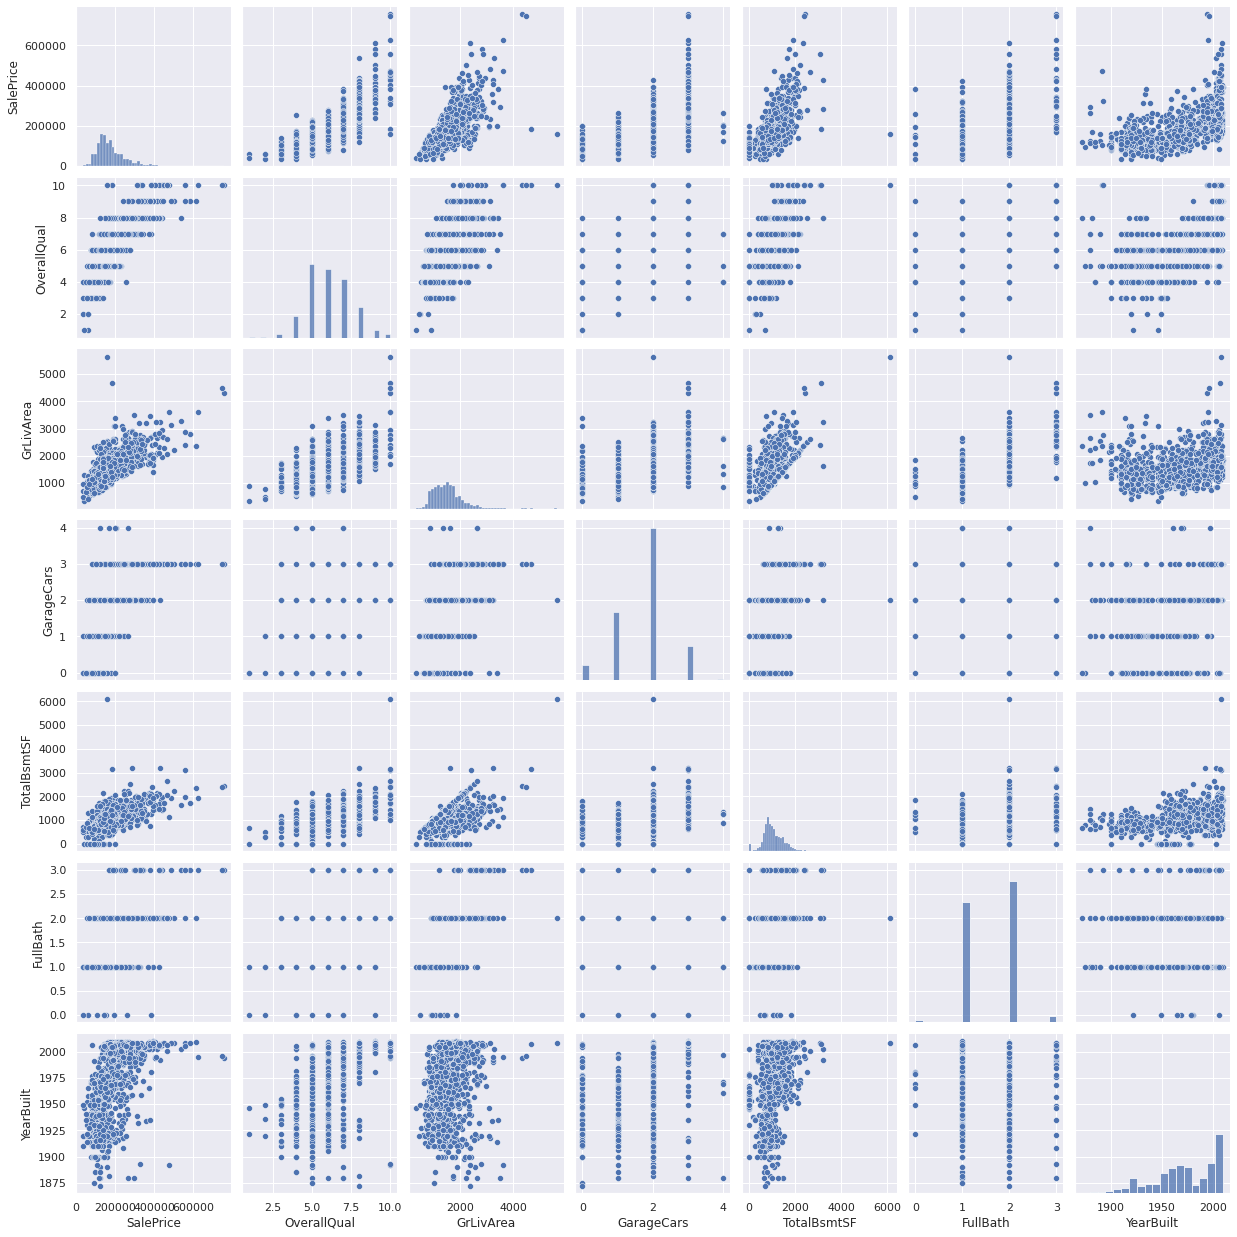

In [15]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

In [16]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
y_train = df_train.SalePrice.values
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


In [17]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657
MiscFeature,96.403
Alley,93.217
Fence,80.439
FireplaceQu,48.647
LotFrontage,16.650
GarageFinish,5.447
GarageQual,5.447
GarageCond,5.447
GarageYrBlt,5.447


Text(0.5, 1.0, 'Percent missing data by feature')

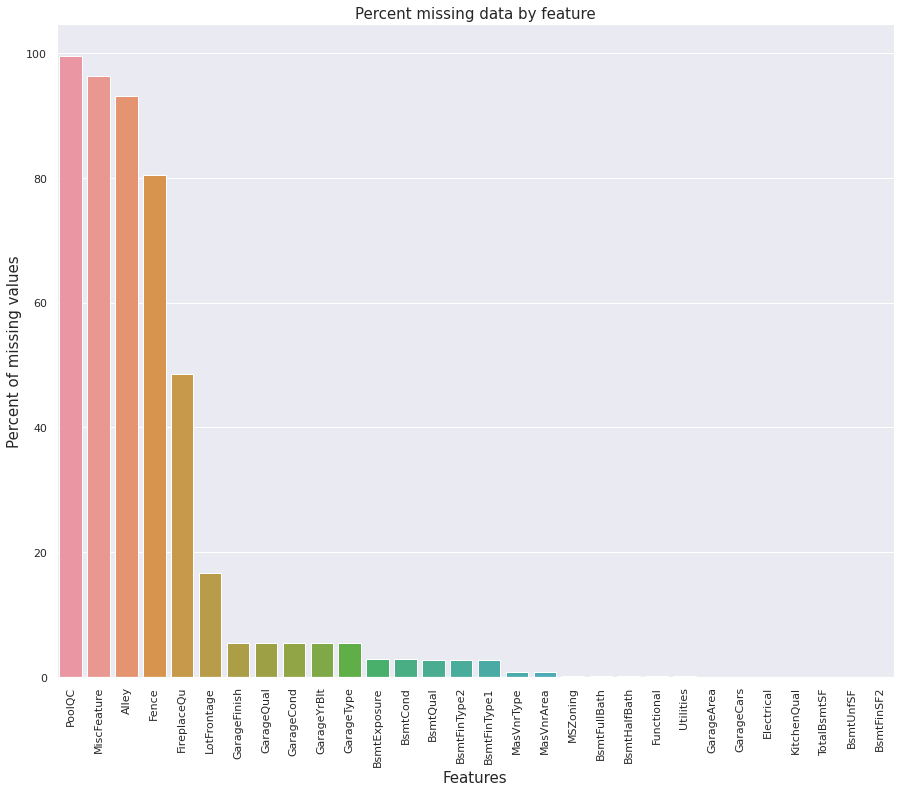

In [18]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

# 3. Preparing the Data


 mu = 12.02 and sigma = 0.40



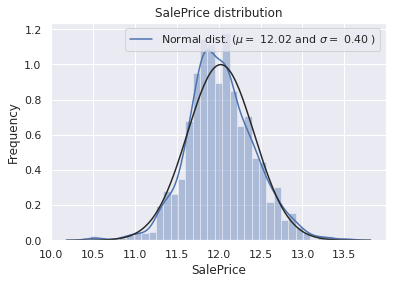

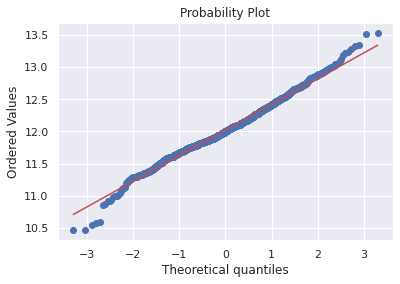

In [19]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

#Check the new distribution 
sns.distplot(df_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

* **PoolQC** : data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.

In [20]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

* **MiscFeature** : data description says NA means "no misc feature"

In [21]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

* **Alley** : data description says NA means "no alley access"

In [22]:
all_data["Alley"] = all_data["Alley"].fillna("None")

* **Fence** : data description says NA means "no fence"

In [23]:
all_data["Fence"] = all_data["Fence"].fillna("None")

* **FireplaceQu** : data description says NA means "no fireplace"

In [24]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

* **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood**.

In [25]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

* **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None

In [26]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

* **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [27]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

* **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [28]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

* **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no basement.

In [29]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

* **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [30]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

* **MSZoning (The general zoning classification)** : 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [31]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

* **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, **this feature won't help in predictive modelling**. We can then safely remove it.

In [32]:
all_data = all_data.drop(['Utilities'], axis=1)

* **Functional** : data description says NA means typical

In [33]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

* **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [34]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

* **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

In [35]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

* **Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

In [36]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

* **SaleType** : Fill in again with most frequent which is "WD"

In [37]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

* **MSSubClass** : Na most likely means No building class. We can replace missing values with None

In [38]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [39]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [40]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [41]:
all_data.shape

(2919, 78)

In [42]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 78)


In [43]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [44]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.947
PoolArea,16.898
LotArea,12.822
LowQualFinSF,12.089
3SsnPorch,11.376
LandSlope,4.975
KitchenAbvGr,4.302
BsmtFinSF2,4.146
EnclosedPorch,4.004
ScreenPorch,3.947


In [45]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


In [46]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 221)


In [47]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [48]:
X_train = train
X_test = test

# 4. Promising Models

I am going to test this models:
* Multiple Linear Regression
* Lasso Regression
* Support Vector Machines
* Random Forests
* XGBoost

In [49]:
# Import libraries

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

## Base models

* **Multiple Linear Regression**:

In [50]:
lm = make_pipeline(RobustScaler(), LinearRegression())

np.mean(-cross_val_score(lm, X_train, y_train, scoring = 'neg_mean_absolute_error', cv= 5))

766977827398.8387

* **LASSO Regression** :
This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's **Robustscaler()** method on pipeline

In [51]:
lm_l = make_pipeline(RobustScaler(), Lasso(random_state=1))

np.mean(-cross_val_score(lm_l, X_train, y_train, scoring = 'neg_mean_absolute_error', cv= 5))

20230.042568710385

,alpha,error
10,110,-18266.265


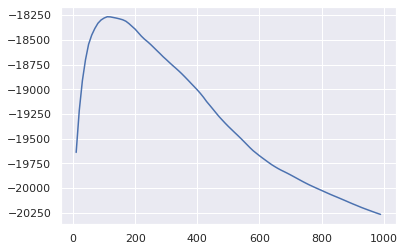

In [52]:
alpha = []
error = []

for i in range(1,100):
    alpha.append(i*10)
    lml = make_pipeline(RobustScaler(), Lasso(alpha =(i*10), random_state=1))
    error.append(np.mean(cross_val_score(lml, X_train, y_train, scoring = 'neg_mean_absolute_error', cv= 5)))
    
plt.plot(alpha,error)

err = tuple(zip(alpha,error))
df_err = pd.DataFrame(err, columns = ['alpha','error'])
df_err[df_err.error == max(df_err.error)]

In [53]:
alpha_optimum = df_err[df_err.error == max(df_err.error)]['alpha'].values[0]
alpha_optimum

110

In [54]:
lm_l = make_pipeline(RobustScaler(), Lasso(alpha = alpha_optimum, random_state=1))

np.mean(-cross_val_score(lm_l, X_train, y_train, scoring = 'neg_mean_absolute_error', cv= 5))

18266.265128825013

* **Support Vector Machine** :

In [55]:
svm_reg = make_pipeline(LinearSVR(random_state=1))

np.mean(-cross_val_score(svm_reg, X_train, y_train, scoring = 'neg_mean_absolute_error', cv= 5))

42584.73021186305

In [56]:
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}

rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=5, random_state=1)

np.mean(-cross_val_score(rnd_search_cv, X_train, y_train, scoring = 'neg_mean_absolute_error', cv= 5))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .....C=5.17022004702574, gamma=0.027583475549166736; total time=   0.2s
[CV] END .....C=5.17022004702574, gamma=0.027583475549166736; total time=   0.2s
[CV] END .....C=5.17022004702574, gamma=0.027583475549166736; total time=   0.2s
[CV] END .....C=5.17022004702574, gamma=0.027583475549166736; total time=   0.2s
[CV] END .....C=5.17022004702574, gamma=0.027583475549166736; total time=   0.2s
[CV] END ..C=1.0011437481734489, gamma=0.0040240664647146086; total time=   0.2s
[CV] END ..C=1.0011437481734489, gamma=0.0040240664647146086; total time=   0.2s
[CV] END ..C=1.0011437481734489, gamma=0.0040240664647146086; total time=   0.2s
[CV] END ..C=1.0011437481734489, gamma=0.0040240664647146086; total time=   0.2s
[CV] END ..C=1.0011437481734489, gamma=0.0040240664647146086; total time=   0.2s
[CV] END ...C=2.4675589081711307, gamma=0.001529949829431263; total time=   0.2s
[CV] END ...C=2.4675589081711307, gamma=0.001529

55483.04392103719

* **Random Forests** :

In [57]:
rf = RandomForestRegressor()

np.mean(-cross_val_score(rf, X_train, y_train,scoring = 'neg_mean_absolute_error', cv= 5))

17313.88000684931

* **XGBoost** :

In [58]:
xgbr = xgb.XGBRegressor()

np.mean(-cross_val_score(xgbr, X_train, y_train, scoring = 'neg_mean_absolute_error', cv= 5))

17321.418233625856

Preliminary results

Scoring: mean absolute error

* Multiple Linear Regression (>>>)
* Lasso Regression (20230)
* Lasso Regression optimized (18266)
* Support Vector Machines, Linear Kernel (42585)
* Support Vector Machines, Non-linear Kernel (55437)
* Random Forests (17394)
* **XGBoost (17321)**

Best model: XGBoost

# 5. Fine-Tune the System

Model: XGBoost

In [59]:
# Create training and validation set from the training data

X_train_train, X_train_validation, y_train_train, y_train_validation = train_test_split(X_train, y_train, test_size=0.2)

In [60]:
# Create function to train XGBoostRegressor model with early stopping, evaluating the MAE from the validation set to obtain the optimum number of iterations

def model_fit(model, early_stopping_rounds, eval_metric = 'mae'):
    
    # Fit model on the training set and evaluate on the validation set
    model.fit(X_train_train, y_train_train, 
            eval_set = [(X_train_train, y_train_train), 
                      (X_train_validation, y_train_validation)], 
            eval_metric = eval_metric,
            early_stopping_rounds = early_stopping_rounds)
    
    # Print optimum number of trees, best iteration (= #opt trees - 1) and best score from the Early Stopping Rounds
    print("---------------------------------------------\nModel Report")
    print("Optimum number of trees: %d" % model.best_ntree_limit)
    print("Best iteration: %d" % model.best_iteration)
    print("Best score: %d" % model.best_score)
    print("---------------------------------------------")
    
    # Plot best result
    results = model.evals_result()
    plt.figure(figsize=(10,7))
    plt.plot(results["validation_0"]["mae"], label="Training MAE")
    plt.plot(results["validation_1"]["mae"], label="Validation MAE")
    plt.axvline(model.best_ntree_limit, color="gray", label="Optimal tree number")
    plt.xlabel("Number of trees")
    plt.ylabel("MAE")
    plt.legend()
    
    # Plot Feature Importances of Top 20 most important features
    plot_importance(model, max_num_features=20)

[0]	validation_0-mae:163744.62500	validation_1-mae:160899.07812
[1]	validation_0-mae:147651.23438	validation_1-mae:145158.23438
[2]	validation_0-mae:133165.28125	validation_1-mae:130948.76562
[3]	validation_0-mae:120122.46875	validation_1-mae:118318.08594
[4]	validation_0-mae:108411.45312	validation_1-mae:106777.61719
[5]	validation_0-mae:97769.98438	validation_1-mae:96321.20312
[6]	validation_0-mae:88251.01562	validation_1-mae:86893.63281
[7]	validation_0-mae:79625.41406	validation_1-mae:78454.21875
[8]	validation_0-mae:71874.42969	validation_1-mae:71038.53125
[9]	validation_0-mae:64828.85547	validation_1-mae:64162.72656
[10]	validation_0-mae:58521.71094	validation_1-mae:58172.26562
[11]	validation_0-mae:52947.23438	validation_1-mae:52787.41797
[12]	validation_0-mae:47921.52734	validation_1-mae:48096.21094
[13]	validation_0-mae:43355.99219	validation_1-mae:43713.09766
[14]	validation_0-mae:39252.58984	validation_1-mae:39901.74609
[15]	validation_0-mae:35657.32031	validation_1-mae:3670

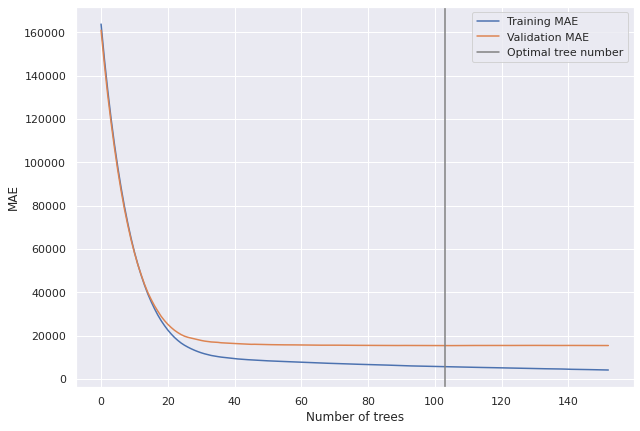

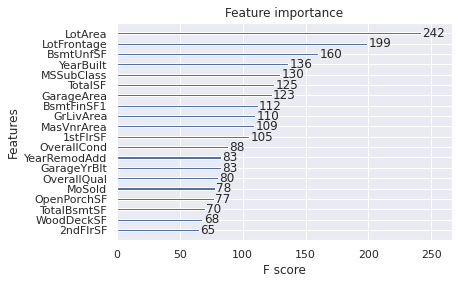

In [61]:
model_1 = xgb.XGBRegressor(n_estimators=1000, 
                         max_depth=5, 
                         learning_rate=0.1,
                         min_child_weight=1, # default
                         gamma=0, # default
                         subsample=0.8, 
                         colsample_bytree=0.8,
                         scale_pos_weight=1, # default
                         reg_alpha=0, # default
                         reg_lambda=1, # default
                         seed=10)

model_fit(model_1, early_stopping_rounds=50)

Tune **max_depth** and **min_child_weight**

In [62]:
# Define parameter grid
param_test1 = {
 'max_depth':range(1,10,2), # before was 5, now Grid Search on [1, 3, 5, 7, 9]; >max_depth --> >over-fitting
 'min_child_weight':range(1,6,2) # before was 1, now Grid Search on [1, 3, 5] ; >min_child_weight --> <over-fitting
}

# Fit model with GridSearchCV to fin optimum 'max_depth' & 'min_child_weight' values (the other values remain fixed)
xgb1 = xgb.XGBRegressor(learning_rate =0.1, 
        n_estimators=model_1.best_ntree_limit,  # Found with early stopping 
        max_depth=5,
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8, 
        reg_alpha=0, 
        reg_lambda=1,
        scale_pos_weight=1,
        seed=10)
gsearch1 = GridSearchCV(xgb1,
    param_test1, 
    scoring='neg_mean_absolute_error',   
    cv=5,
    verbose=True)

gsearch1.fit(X_train_train, y_train_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


({'mean_fit_time': array([0.16278129, 0.23232565, 0.17153292, 0.30542793, 0.29495506,
         0.28550649, 0.42148643, 0.42572641, 0.56950336, 0.57655048,
         0.54990454, 0.53241444, 0.7491797 , 0.67835321, 0.65119991]),
  'std_fit_time': array([0.00123918, 0.127577  , 0.00219491, 0.03272487, 0.00586252,
         0.00344857, 0.0036944 , 0.01330103, 0.19966232, 0.01739075,
         0.00607318, 0.00289559, 0.03737484, 0.00818257, 0.01032779]),
  'mean_score_time': array([0.00333529, 0.00352798, 0.0036541 , 0.00511203, 0.00386934,
         0.00363731, 0.0038228 , 0.00381398, 0.00693569, 0.00421314,
         0.00407271, 0.00414405, 0.00497832, 0.00433755, 0.00441365]),
  'std_score_time': array([4.78399578e-05, 5.58350861e-05, 1.38746717e-04, 2.85949917e-03,
         2.26096923e-04, 4.05698479e-05, 7.60714446e-05, 7.82357408e-05,
         3.96986691e-03, 1.02800982e-04, 1.04284014e-04, 1.92278197e-04,
         8.05330001e-04, 2.22632660e-04, 3.05136194e-04]),
  'param_max_depth': mask

Optimum values:

* **'max_depth'**: 5
* **'min_child_weight'**: 3

I'll further tune both parameters with 1 above and 1 below of each one:

* **'max_depth'**: [4, 5, 6]
* **'min_child_weight'**: [2, 3, 4]

In [63]:
# Define parameter grid
param_test2 = {
 'max_depth': [4, 5, 6],
 'min_child_weight': [2, 3, 4]
}

# Fit model with GridSearchCV to fin optimum 'max_depth' & 'min_child_weight' values (the other values remain fixed)
xgb2 = xgb.XGBRegressor(learning_rate =0.1, 
        n_estimators=model_1.best_ntree_limit,  # Found with early stopping
        max_depth=5,
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8, 
        reg_alpha=0, 
        reg_lambda=1,
        scale_pos_weight=1,
        seed=10)
gsearch2 = GridSearchCV(xgb2,
    param_test2, 
    scoring='neg_mean_absolute_error',   
    cv=5,
    verbose=True)

gsearch2.fit(X_train_train, y_train_train)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


({'mean_fit_time': array([0.36256132, 0.36900959, 0.36302705, 0.43366399, 0.43452086,
         0.57956371, 0.51597238, 0.48515439, 0.48126621]),
  'std_fit_time': array([0.00753975, 0.01924477, 0.00568159, 0.01222113, 0.01270121,
         0.18615768, 0.01887927, 0.00270556, 0.00880369]),
  'mean_score_time': array([0.00395207, 0.00391998, 0.00380988, 0.00400643, 0.00401378,
         0.00443201, 0.00414248, 0.00411587, 0.00440221]),
  'std_score_time': array([2.31007126e-04, 2.21257405e-04, 3.98484114e-05, 1.71718019e-04,
         1.33891000e-04, 9.11092752e-04, 1.68484146e-04, 3.54500941e-04,
         7.83687134e-04]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[2, 3, 4, 2, 3, 4, 2, 3, 4],
               mask=[False, False, False, False, False, False, False, 

Optimum values:

* **'max_depth'**: 5
* **'min_child_weight'**: 3

Values didn't change so I'll leave them fixed from now on.

Tune **gamma**

In [64]:
# Define parameter grid
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)] # gamma = [0, 0.1, 0.2, 0.3, 0.4]; the default is 0; >gamma means a > minimum loss reduction requirement to make a split (makes the algoritm more conservative)
}

# Fit model with GridSearchCV to find optimum 'gamma' values (the other values remain fixed)
xgb3 = xgb.XGBRegressor(learning_rate =0.1, 
        n_estimators=model_1.best_ntree_limit,  # Found with early stopping
        max_depth=5, # Found with GridSearchCV
        min_child_weight=3, # Found with GridSearchCV
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8, 
        reg_alpha=0, 
        reg_lambda=1,
        scale_pos_weight=1,
        seed=10)
gsearch3 = GridSearchCV(xgb3,
    param_test3, 
    scoring='neg_mean_absolute_error',   
    cv=5,
    verbose=True)

gsearch3.fit(X_train_train, y_train_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


({'mean_fit_time': array([0.44164057, 0.42695723, 0.43073959, 0.42946243, 0.4309154 ]),
  'std_fit_time': array([0.03065596, 0.00214697, 0.00676542, 0.00607268, 0.00305947]),
  'mean_score_time': array([0.00388098, 0.0040751 , 0.0042644 , 0.00391726, 0.00401406]),
  'std_score_time': array([5.90926112e-05, 2.93827405e-04, 6.11725828e-04, 3.65138346e-05,
         1.50841570e-04]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([-16236.73914931, -16236.73914931, -16236.73914931, -16236.73914931,
         -16236.73914931]),
  'split1_test_score': array([-16275.20314169, -16275.20314169, -16275.20314169, -16275.20314169,
         -16275.20314169]),
  'split2_test_score': array([-14528.51595887, -14528.51595887, -14528.51595887, -1452

Optimum value:

* **'gamma'**: 0.0

The default 'gamma' value of 0 was the optimum so I'll keep it fixed from now on.

Before proceeding, I'm going to re-calibrate the number of boosting rounds for the updated parameters.

[0]	validation_0-mae:163731.75000	validation_1-mae:160925.90625
[1]	validation_0-mae:147636.45312	validation_1-mae:145215.45312
[2]	validation_0-mae:133119.89062	validation_1-mae:130990.41406
[3]	validation_0-mae:120097.89062	validation_1-mae:118301.61719
[4]	validation_0-mae:108339.41406	validation_1-mae:106789.71875
[5]	validation_0-mae:97679.09375	validation_1-mae:96372.20312
[6]	validation_0-mae:88227.09375	validation_1-mae:86987.46875
[7]	validation_0-mae:79617.75781	validation_1-mae:78617.91406
[8]	validation_0-mae:71918.02344	validation_1-mae:71220.10938
[9]	validation_0-mae:64924.95312	validation_1-mae:64271.79297
[10]	validation_0-mae:58648.51562	validation_1-mae:58287.65234
[11]	validation_0-mae:53119.50000	validation_1-mae:52911.68359
[12]	validation_0-mae:48099.83594	validation_1-mae:48088.47266
[13]	validation_0-mae:43557.42969	validation_1-mae:43629.76562
[14]	validation_0-mae:39499.10547	validation_1-mae:39834.75781
[15]	validation_0-mae:35892.39062	validation_1-mae:3661

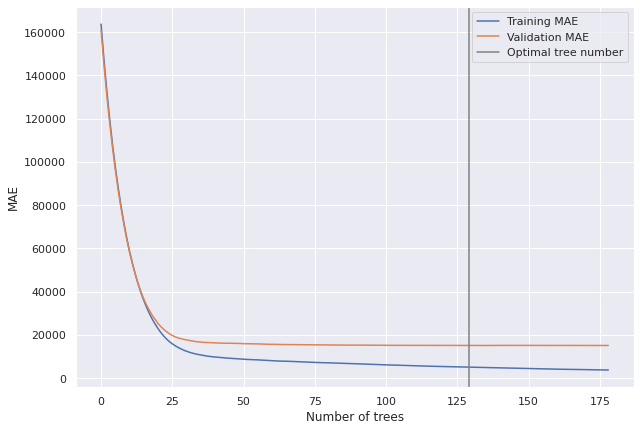

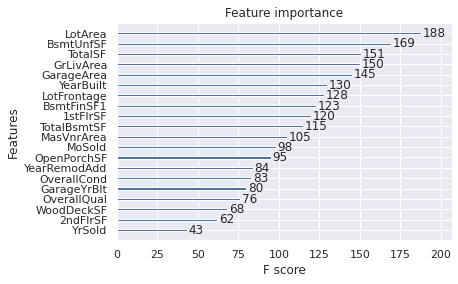

In [65]:
model_2 = xgb.XGBRegressor(n_estimators=1000, 
                         max_depth=5, # optimized
                         learning_rate=0.1,
                         min_child_weight=3, # optimized
                         gamma=0, # optimized
                         subsample=0.8, 
                         colsample_bytree=0.8,
                         scale_pos_weight=1, # default
                         reg_alpha=0, # default
                         reg_lambda=1, # default
                         seed=10)

model_fit(model_2, early_stopping_rounds=50)

Tune **subsample** and **colsample_bytree**

In [66]:
# Define parameter grid
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)], # [0.6, 0.7, 0.8, 0.9]
 'colsample_bytree':[i/10.0 for i in range(6,10)] # [0.6, 0.7, 0.8, 0.9]
}

# Fit model with GridSearchCV to find optimum 'subsample' & 'colsample_bytree' values (the other values remain fixed)
xgb4 = xgb.XGBRegressor(learning_rate =0.1, 
        n_estimators=model_2.best_ntree_limit,  # Found with early stopping
        max_depth=5, # Found with GridSearchCV
        min_child_weight=3, # Found with GridSearchCV
        gamma=0, # Found with GridSearchCV
        subsample=0.8, 
        colsample_bytree=0.8, 
        reg_alpha=0, 
        reg_lambda=1,
        scale_pos_weight=1,
        seed=10)
gsearch4 = GridSearchCV(xgb4,
    param_test4, 
    scoring='neg_mean_absolute_error',   
    cv=5,
    verbose=True)

gsearch4.fit(X_train_train, y_train_train)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


({'mean_fit_time': array([0.45557437, 0.45318799, 0.58692865, 0.44896288, 0.4924017 ,
         0.50347877, 0.48535376, 0.49690523, 0.55300941, 0.53680367,
         0.52844129, 0.54056649, 0.5932549 , 0.59479504, 0.75062709,
         0.60609422]),
  'std_fit_time': array([0.0033048 , 0.01034248, 0.1836807 , 0.04009663, 0.00265001,
         0.00579498, 0.00434871, 0.05097085, 0.01077083, 0.00491026,
         0.0077657 , 0.03006326, 0.0076064 , 0.01536724, 0.3399502 ,
         0.02891206]),
  'mean_score_time': array([0.00396881, 0.00391946, 0.00744596, 0.00392489, 0.00390649,
         0.00402174, 0.00409636, 0.00397844, 0.00399985, 0.00396123,
         0.00401974, 0.00414815, 0.00442228, 0.00396709, 0.00448227,
         0.00497155]),
  'std_score_time': array([1.14229782e-04, 7.63549561e-05, 7.11101781e-03, 8.76176309e-05,
         3.74531229e-05, 1.74365638e-04, 2.29852555e-04, 7.80454979e-05,
         1.03242854e-04, 3.86798711e-05, 7.97095747e-05, 2.79267106e-04,
         8.19712084e-

Optimum values:

* **'colsample_bytree'**: 0.9
* **'subsample'**: 0.7

I'll further tune both parameters:

* **'colsample_bytree'**: [0.8, 0.9, 1]
* **'subsample'**: [0.65, 0.70, 0.75]

In [67]:
# Define parameter grid
param_test5 = {
 'subsample':[0.65, 0.70, 0.75],
 'colsample_bytree':[0.8, 0.9, 1]
}

# Fit model with GridSearchCV to find optimum 'subsample' & 'colsample_bytree' values (the other values remain fixed)
xgb5 = xgb.XGBRegressor(learning_rate =0.1, 
        n_estimators=model_2.best_ntree_limit,  # Found with early stopping
        max_depth=5, # Found with GridSearchCV
        min_child_weight=3, # Found with GridSearchCV
        gamma=0, # Found with GridSearchCV
        subsample=0.8, 
        colsample_bytree=0.8, 
        reg_alpha=0, 
        reg_lambda=1,
        scale_pos_weight=1,
        seed=10)
gsearch5 = GridSearchCV(xgb5,
    param_test5, 
    scoring='neg_mean_absolute_error',   
    cv=5,
    verbose=True)

gsearch5.fit(X_train_train, y_train_train)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


({'mean_fit_time': array([0.56640201, 0.54580445, 0.56111245, 0.58271394, 0.58456631,
         0.57817516, 0.64607096, 0.62548485, 0.77366509]),
  'std_fit_time': array([0.00833995, 0.01007937, 0.03520285, 0.00419445, 0.01057718,
         0.01044551, 0.04218793, 0.00742744, 0.31472984]),
  'mean_score_time': array([0.00419121, 0.0042696 , 0.00423069, 0.00401297, 0.00406752,
         0.00417147, 0.00431504, 0.00397615, 0.00398941]),
  'std_score_time': array([2.43697164e-04, 2.42681117e-04, 3.36949527e-04, 1.61956293e-04,
         1.29213949e-04, 3.89675066e-04, 4.82593072e-04, 6.54745170e-05,
         6.28389967e-05]),
  'param_colsample_bytree': masked_array(data=[0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 1, 1, 1],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.65, 0.7, 0.75, 0.65, 0.7, 0.75, 0.65, 0.7, 0.75],
               mask=[False, False,

Optimum values:

* **'colsample_bytree'**: 0.9
* **'subsample'**: 0.7

They didn't change so I'll leave them fixed from now on.

Tune **reg_alpha** and **reg_lambda**

In [68]:
# Define parameter grid
param_test6 = {
 'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[1, 10, 20, 50, 100, 1000]
}

# Fit model with GridSearchCV to find optimum 'reg_alpha' & 'reg_lambda' values (the other values remain fixed)
xgb6 = xgb.XGBRegressor(learning_rate =0.1, 
        n_estimators=model_2.best_ntree_limit,  # Found with early stopping
        max_depth=5, # Found with GridSearchCV
        min_child_weight=3, # Found with GridSearchCV
        gamma=0, # Found with GridSearchCV
        subsample=0.7, # Found with GridSearchCV
        colsample_bytree=0.9, # Found with GridSearchCV
        reg_alpha=0, 
        reg_lambda=1,
        scale_pos_weight=1,
        seed=10)
gsearch6 = GridSearchCV(xgb6,
    param_test6, 
    scoring='neg_mean_absolute_error',   
    cv=5,
    verbose=True)

gsearch6.fit(X_train_train, y_train_train)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


({'mean_fit_time': array([0.5869278 , 0.56973596, 0.57689409, 0.59662485, 0.58732524,
         0.55857868, 0.576404  , 0.59098797, 0.57612109, 0.75066285,
         0.59615731, 0.55937648, 0.57727094, 0.57530646, 0.60600972,
         0.59015627, 0.58132691, 0.55717149, 0.58947206, 0.58675427,
         0.7289351 , 0.59306054, 0.58540239, 0.56300468, 0.57575426,
         0.57675672, 0.55852456, 0.5617125 , 0.55823956, 0.56426969,
         0.63317556, 0.63199849, 0.5607492 , 0.56551738, 0.56168146,
         0.54749765]),
  'std_fit_time': array([0.01114748, 0.00260905, 0.00724214, 0.03382271, 0.00695403,
         0.00844208, 0.00858593, 0.0363581 , 0.00759716, 0.33162706,
         0.03573596, 0.00379814, 0.00543709, 0.00538222, 0.03810819,
         0.00837828, 0.00725578, 0.0034339 , 0.0197412 , 0.01981426,
         0.28924662, 0.04181638, 0.00936842, 0.00458241, 0.00780789,
         0.03584562, 0.00554352, 0.00358137, 0.0020271 , 0.02970336,
         0.12309244, 0.15952662, 0.00600417, 0.

Optimum values:

* **'reg_alpha'**: 1e-05
* **'reg_lambda'**: 1

I'll further tune **'reg_alpha'**:

* **'reg_alpha'**: [1e-6, 1e-5, 1e-4]

In [69]:
# Define parameter grid
param_test7 = {
 'reg_alpha':[1e-6, 1e-5, 1e-4]
}

# Fit model with GridSearchCV to find optimum 'reg_alpha' & 'reg_lambda' values (the other values remain fixed)
xgb7 = xgb.XGBRegressor(learning_rate =0.1, 
        n_estimators=model_2.best_ntree_limit,  # Found with early stopping
        max_depth=5, # Found with GridSearchCV
        min_child_weight=3, # Found with GridSearchCV
        gamma=0, # Found with GridSearchCV
        subsample=0.7, # Found with GridSearchCV
        colsample_bytree=0.9, # Found with GridSearchCV
        reg_alpha=0, 
        reg_lambda=1, # Found with GridSearchCV
        scale_pos_weight=1,
        seed=10)
gsearch7 = GridSearchCV(xgb7,
    param_test7, 
    scoring='neg_mean_absolute_error',   
    cv=5,
    verbose=True)

gsearch7.fit(X_train_train, y_train_train)
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


({'mean_fit_time': array([0.58542752, 0.56144948, 0.56118498]),
  'std_fit_time': array([0.03748578, 0.00544036, 0.00386714]),
  'mean_score_time': array([0.00421085, 0.00376687, 0.00380387]),
  'std_score_time': array([7.61552259e-04, 2.60501512e-05, 5.97721797e-05]),
  'param_reg_alpha': masked_array(data=[1e-06, 1e-05, 0.0001],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-06},
   {'reg_alpha': 1e-05},
   {'reg_alpha': 0.0001}],
  'split0_test_score': array([-16467.07027911, -16467.07027911, -16467.07027911]),
  'split1_test_score': array([-17132.34595353, -17132.34595353, -17132.34595353]),
  'split2_test_score': array([-13387.72519364, -13387.72519364, -13387.72526042]),
  'split3_test_score': array([-16161.08432806, -16161.08432806, -16161.08432806]),
  'split4_test_score': array([-15970.03674893, -15970.03674893, -15970.03621245]),
  'mean_test_score': array([-15823.65250065, -15823.65250065, -15823

Optimum values:

* **'reg_alpha'**: 0.0001

I'll leave it fixed from now on.

I'm going to re-calibrate the number of boosting rounds for the updated parameters.

[0]	validation_0-mae:163778.98438	validation_1-mae:160902.54688
[1]	validation_0-mae:147679.18750	validation_1-mae:145149.71875
[2]	validation_0-mae:133194.71875	validation_1-mae:131020.65625
[3]	validation_0-mae:120135.75000	validation_1-mae:118485.52344
[4]	validation_0-mae:108462.91406	validation_1-mae:106874.30469
[5]	validation_0-mae:97957.82812	validation_1-mae:96523.82812
[6]	validation_0-mae:88451.62500	validation_1-mae:87256.71875
[7]	validation_0-mae:79914.96094	validation_1-mae:78922.07812
[8]	validation_0-mae:72220.56250	validation_1-mae:71752.23438
[9]	validation_0-mae:65233.66406	validation_1-mae:65044.32812
[10]	validation_0-mae:58925.61719	validation_1-mae:58928.78906
[11]	validation_0-mae:53376.04297	validation_1-mae:53548.31641
[12]	validation_0-mae:48345.06250	validation_1-mae:48821.26562
[13]	validation_0-mae:43811.93750	validation_1-mae:44439.00781
[14]	validation_0-mae:39653.92969	validation_1-mae:40600.49219
[15]	validation_0-mae:36051.97656	validation_1-mae:3727

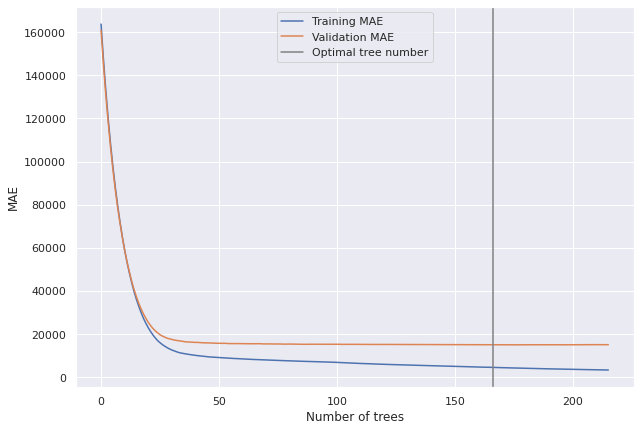

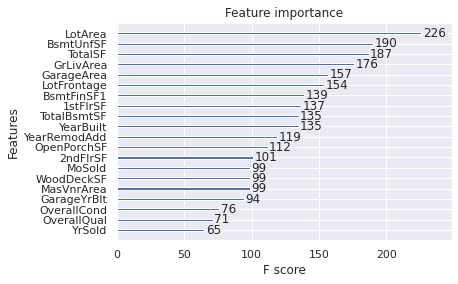

In [70]:
model_3 = xgb.XGBRegressor(n_estimators=1000, 
                         max_depth=5, # optimized
                         learning_rate=0.1,
                         min_child_weight=3, # optimized
                         gamma=0, # optimized
                         subsample=0.7, # optimized
                         colsample_bytree=0.9, # optimized
                         scale_pos_weight=1, # default
                         reg_alpha=0.0001, # optimized
                         reg_lambda=1, # optimized
                         seed=10)

model_fit(model_3, early_stopping_rounds=50)

Tune **learning_rate**

In [71]:
# Define parameter grid
param_test8 = {
 'learning_rate':[0.01, 0.05, 0.1, 0.5, 1]
}

# Fit model with GridSearchCV to find optimum 'reg_alpha' & 'reg_lambda' values (the other values remain fixed)
xgb8 = xgb.XGBRegressor(learning_rate =0.1, 
        n_estimators=model_3.best_ntree_limit,  # Found with early stopping
        max_depth=5, # Found with GridSearchCV
        min_child_weight=3, # Found with GridSearchCV
        gamma=0, # Found with GridSearchCV
        subsample=0.7, # Found with GridSearchCV
        colsample_bytree=0.9, # Found with GridSearchCV
        reg_alpha=0.0001, # Found with GridSearchCV
        reg_lambda=1, # Found with GridSearchCV
        scale_pos_weight=1,
        seed=10)
gsearch8 = GridSearchCV(xgb8,
    param_test8, 
    scoring='neg_mean_absolute_error',   
    cv=5,
    verbose=True)

gsearch8.fit(X_train_train, y_train_train)
gsearch8.cv_results_, gsearch8.best_params_, gsearch8.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


({'mean_fit_time': array([0.89080815, 0.71587367, 0.7342154 , 0.7367907 , 0.7363266 ]),
  'std_fit_time': array([0.31522111, 0.00663117, 0.0393523 , 0.01268726, 0.0053599 ]),
  'mean_score_time': array([0.00389543, 0.00396161, 0.00387211, 0.00385804, 0.00395694]),
  'std_score_time': array([6.93149034e-05, 1.09295758e-04, 5.15152762e-05, 6.39371598e-05,
         1.33007022e-04]),
  'param_learning_rate': masked_array(data=[0.01, 0.05, 0.1, 0.5, 1],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate': 0.01},
   {'learning_rate': 0.05},
   {'learning_rate': 0.1},
   {'learning_rate': 0.5},
   {'learning_rate': 1}],
  'split0_test_score': array([-39029.16553152, -16786.49816373, -16522.68880208, -22189.70547877,
         -33605.5947683 ]),
  'split1_test_score': array([-39382.03978032, -16613.88778713, -17210.26674346, -24022.63115986,
         -33356.01643672]),
  'split2_test_score': array([-34820.3

[0]	validation_0-mae:163778.98438	validation_1-mae:160902.54688
[1]	validation_0-mae:147679.17188	validation_1-mae:145149.71875
[2]	validation_0-mae:133194.71875	validation_1-mae:131020.65625
[3]	validation_0-mae:120135.75000	validation_1-mae:118485.52344
[4]	validation_0-mae:108462.91406	validation_1-mae:106874.30469
[5]	validation_0-mae:97957.82031	validation_1-mae:96523.82812
[6]	validation_0-mae:88451.61719	validation_1-mae:87256.71875
[7]	validation_0-mae:79914.96094	validation_1-mae:78922.07812
[8]	validation_0-mae:72220.56250	validation_1-mae:71752.23438
[9]	validation_0-mae:65233.66406	validation_1-mae:65044.33594
[10]	validation_0-mae:58925.61719	validation_1-mae:58928.78906
[11]	validation_0-mae:53376.04297	validation_1-mae:53548.31641
[12]	validation_0-mae:48345.06250	validation_1-mae:48821.26562
[13]	validation_0-mae:43811.94141	validation_1-mae:44439.00781
[14]	validation_0-mae:39653.92969	validation_1-mae:40600.49219
[15]	validation_0-mae:36051.97656	validation_1-mae:3727

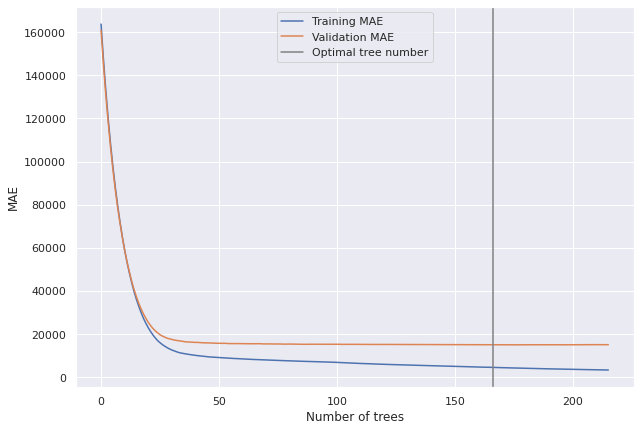

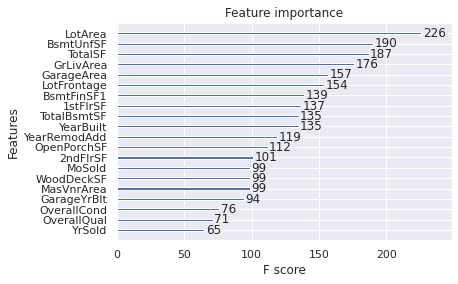

In [72]:
model_4 = xgb.XGBRegressor(n_estimators=1000, 
                         max_depth=5, # optimized
                         learning_rate=0.1, # optimized
                         min_child_weight=3, # optimized
                         gamma=0, # optimized
                         subsample=0.7, # optimized
                         colsample_bytree=0.9, # optimized
                         scale_pos_weight=1, # default
                         reg_alpha=0.0001, # optimized
                         reg_lambda=1, # optimized
                         seed=10)

model_fit(model_4, early_stopping_rounds=50)

In [73]:
Y_pred = model_4.predict(X_test)

In [74]:
submission_xgb = pd.DataFrame({
        "Id": test_ID.values,
        "SalePrice": Y_pred
    })

submission_xgb.to_csv('submission_xgb.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
